In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [ ]:
class DatasetConfig:
    DATA_PATH = 'dataset'
    TRAIN_CSV = os.path.join(DATA_PATH, 'train.csv')
    TEST_CSV = os.path.join(DATA_PATH, 'test.csv')
    IMAGE_SIZE = (128, 128)
    BATCH_SIZE = 32
    EPOCHS = 10
    MODEL_FILE = 'AI-vs-Human-Classifier.keras'

In [5]:
train_df = pd.read_csv(DatasetConfig.TRAIN_CSV)
test_df = pd.read_csv(DatasetConfig.TEST_CSV)


In [6]:
train_df["file_name"] = train_df["file_name"].apply(lambda x: os.path.join(DatasetConfig.DATA_PATH, x))
train_df = train_df.dropna(subset=["file_name", "label"])
train_df = train_df[train_df["file_name"].apply(os.path.exists)]
train_df["label"] = train_df["label"].astype(str).apply(lambda x: "human" if x.strip() == "0" else "ai")


In [7]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)


In [8]:
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col="file_name",
    y_col="label",
    target_size=DatasetConfig.IMAGE_SIZE,
    batch_size=DatasetConfig.BATCH_SIZE,
    class_mode="binary",
    subset="training"
)

val_generator = datagen.flow_from_dataframe(
    train_df,
    x_col="file_name",
    y_col="label",
    target_size=DatasetConfig.IMAGE_SIZE,
    batch_size=DatasetConfig.BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)

Found 71955 validated image filenames belonging to 2 classes.
Found 7995 validated image filenames belonging to 2 classes.


In [9]:
if train_generator.n == 0 or val_generator.n == 0:
    raise ValueError("Error: Training or validation generator is empty. Check dataset paths and labels.")


In [10]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


In [13]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=DatasetConfig.EPOCHS
)


Epoch 1/10
2249/2249 [==============================] - 1449s 644ms/step - loss: 0.2596 - accuracy: 0.8997 - val_loss: 0.2003 - val_accuracy: 0.9212
Epoch 2/10
2249/2249 [==============================] - 1337s 594ms/step - loss: 0.2204 - accuracy: 0.9172 - val_loss: 0.1873 - val_accuracy: 0.9272
Epoch 3/10
2249/2249 [==============================] - 1209s 538ms/step - loss: 0.2042 - accuracy: 0.9230 - val_loss: 0.1701 - val_accuracy: 0.9351
Epoch 4/10
2249/2249 [==============================] - 1280s 569ms/step - loss: 0.1870 - accuracy: 0.9310 - val_loss: 0.1436 - val_accuracy: 0.9455
Epoch 5/10
2249/2249 [==============================] - 1543s 686ms/step - loss: 0.1762 - accuracy: 0.9349 - val_loss: 0.1840 - val_accuracy: 0.9355
Epoch 6/10
2249/2249 [==============================] - 1392s 619ms/step - loss: 0.1643 - accuracy: 0.9392 - val_loss: 0.1387 - val_accuracy: 0.9472
Epoch 7/10
2249/2249 [==============================] - 1338s 595ms/step - loss: 0.1609 - accuracy: 0.9410

In [ ]:
model.save(DatasetConfig.MODEL_FILE)

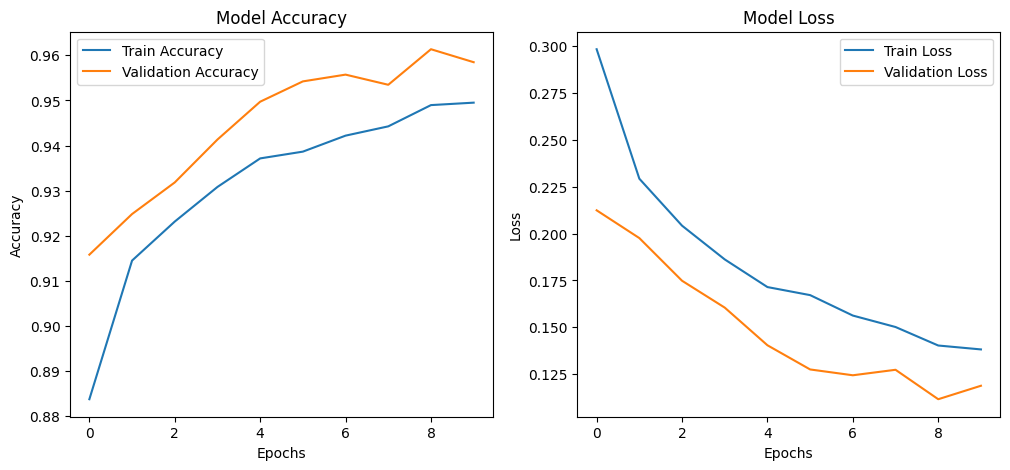

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.show()

plot_training_history(history)

In [ ]:
test_df['id'] = test_df['id'].apply(lambda x: os.path.join(DatasetConfig.DATA_PATH, x))
test_df = test_df[test_df['id'].apply(os.path.exists)]

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'id',
    target_size = DatasetConfig.IMAGE_SIZE,
    batch_size = DatasetConfig.BATCH_SIZE,
    class_mode = None,
    shuffle = False
)

Found 5540 validated image filenames.


In [ ]:
if test_generator.n == 0:
    raise ValueError('Error : Test generator is empty.')

In [ ]:
test_predictions = model.predict(test_generator)
test_df['prediction'] = (test_predictions > 0.5).astype(int)

/Users/prathamsharma/Desktop/Projects/AI-vs-Human/generated-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


174/174 ━━━━━━━━━━━━━━━━━━━━ 147s 846ms/step


In [ ]:
test_df.to_csv('test_predictions.csv', index=False)
print('Predictions saved to test_predictions.csv')

Predictions saved to test_predictions.csv


In [ ]:
def predict_image(image_path, model_path=DatasetConfig.MODEL_FILE):
    model = tf.keras.models.load_model(model_path)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=DatasetConfig.IMAGE_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)[0][0]
    return 'AI-Generated' if prediction > 0.5 else 'Human-Generated'

In [ ]:
if not test_df.empty:
    sample_image = test_df.iloc[2]['id']
    print(f'Prediction for sample image : {predict_image(sample_image)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Prediction for sample image : AI-Generated
